<p style="font-size:19px; text-align:left;"><i>Advanced Applications of Generative AI in Actuarial Science: Case Studies Beyond ChatGPT</i></p>
<p style="font-size:25px; text-align:left; font-weight:bold;">Case Study: Improving Claim Cost Prediction
with LLM-Extracted Features from Unstructured Data</p>
<p style="font-size:19px; text-align:left; margin-top: -10px; margin-bottom: 15px;">Simon Hatzesberger (<a href="mailto:simon.hatzesberger@gmail.com">simon.hatzesberger@gmail.com</a>), Iris Nonneman (<a href="mailto:irisnonneman@gmail.com">irisnonneman@gmail.com</a>)
<p style="font-style:italic; font-size: 19px">Date: June 15, 2025</p>


This notebook demonstrates how to leverage Large Language Models (LLMs) to extract structured information from unstructured insurance claim descriptions, focusing on identifying injured body parts and cause of injury.
We show how this additional information from claim text can be transformed to meaningful features to improve claim cost prediction.
In doing so we will use a data set consisting of information regarding workers claim compensation.  




1. **Data Preparation**:
    - Load and inspect the dataset.
    - Handle missing values.
    - Convert categorical variables into numerical format using one-hot encoding.
    - Extract and engineer features from date columns.

2. **Feature Engineering**:
    - Extract meaningful features from the 'ClaimDescription' text, such as the number of body parts injured, main body part injured, and cause of injury.
    - Categorize the body parts and causes of injury into predefined categories using regular expressions.
    - Create new features based on the date and time of the accident and the date reported.

3. **Target Variable Transformation**:
    - Apply log transformation to the target variable 'UltimateIncurredClaimCost' to handle skewness in the data distribution.

4. **Model Training and Evaluation**:
    - Split the data into a training and testing set.
    - Train a Gradient Boosting Regressor model using the training data.
    - Evaluate the model performance using metrics such as RMSE, MAE, and R2 score.
    - Compare the performance of models trained on baseline features and enhanced features (including text-derived features).

5. **Feature Importance Analysis**:
    - Analyze the importance of different features in predicting the target variable.
    - Visualize the feature importance to understand which features contribute the most to the model's predictions.

6. **Model Comparison**:
    - Compare the performance of the baseline model and the enhanced model.
    - Conduct statistical tests to determine the significance of the performance differences.

7. **Appendix: Hyperparameter tuning with grid search**:
    - Perform cross-validation to ensure the model's robustness.
    - Tune hyperparameters of the Gradient Boosting Regressor to find the best model configuration.

By following these steps, we aim to build a robust predictive model for estimating the claim costs, leveraging both structured data and insights extracted from unstructured text descriptions.

<h1 style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px; padding-left: 14px;">Table of Contents</h1>

[Setup and Configuration](#setup_and_configuration)

[Stage 1: Extracting features with LLM](#stage_1_llm)

[Stage 2: Data Preprocessing](#stage_2_extracting)

[Stage 3: Categorizing LLM extracted content](#stage_3_categorizing)

[Stage 4: Model development & Validation](#stage_4_model)

[Appendix: Hyperparameter optimization with grid search](#appendix_grid)

<h1 id="setup_and_configuration" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">Setup and Configuration</h1>


This section focuses on importing required libraries and establishing configurations for data processing, API integration, and modelling.

First, we import the required libraries to ensure all tools are available for subsequent data processing.

In [ ]:
#Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Data preprocessing and string manipulation
import re
 
# Model training and pipeline management
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
 
# Machine learning models
from sklearn.ensemble import GradientBoostingRegressor
 
# Model evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 
# Cross-validation and hyperparameter tuning
from sklearn.model_selection import KFold, GridSearchCV
 
# Statistical analysis and functions
from scipy import stats

<h1 id="stage_1_llm" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">Stage 1: Extracting features with LLM</h1>

For this case study, we use a dataset of 3,000 workers' compensation claims from a [Kaggle competition on actuarial loss estimation](https://www.kaggle.com/competitions/actuarial-loss-estimation). This dataset is fully synthetic – constructed as a stratified sample from a larger pool of 90,000 realistically simulated records – and includes both structured features (e.g., age, gender, marital status, wages) and unstructured text descriptions of the claim reports.

In a previous notebook, we have run the following code to extract information on claim injury and cause of injury, using OpenAI model gpt-4o-mini.

In [7]:
%%script true
open_api_key = "addyourkeyhere"

In [8]:
%%script true
# OpenAI-Client for communication with openai
#client = OpenAI(api_key=openai_api_key)
# Chosing model
MODEL = "gpt-4o-mini"  

In [9]:
%%script true
system_prompt_adjusted = '''
Your task is to extract structured information about injuries and cause of injury from the given text.  
Follow this schema strictly:

- number_of_body_parts_injured: The total count of injured body parts.  
- main_body_part_injured: The primary body part affected, described concisely (e.g., "HEAD", "THUMB").  
- cause_of_injury: Specify by verb. 
    - If verb given: return only the primary action verb that directly caused the injury (e.g. "fall" not "fell from box")
    - If cause is not mentioned, infer from context if possible, otherwise return "unspecified".

Ensure accuracy and consistency in the extracted details. Do not add interpretations beyond the provided text.
'''


class AdditionalInformation(BaseModel):
    number_of_body_parts_injured: int
    main_body_part_injured: str
    cause_of_injury: str


def parse_info(completion_data):
    """
    Parse injury information from completion.choices[0].message.parsed
    
    Args:
        completion_data: The parsed message data from completion.choices
    
    Returns:
        tuple: (number_of_body_parts, body_part, side)
    """
    parsed = completion_data.choices[0].message.parsed
    
    # Extract values directly from the parsed object
    num_parts = parsed.number_of_body_parts_injured
    body_part = parsed.main_body_part_injured
    cause= parsed.cause_of_injury # Assuming this gets the LEFT/RIGHT value
    
    return num_parts, body_part, cause

def extract_additional_information(text: str):
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        messages=[
            {"role": "system", "content": system_prompt_adjusted},
            {"role": "user", "content": text}
        ],
        response_format=AdditionalInformation,
    )
    result = parse_info(completion)
    return result

<h1 id="stage_2_preprocessing" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">Stage 2: Data preprocessing</h1>

We load the data set which we have already prepared previously.
This data set consists of 3000 claims.

In [10]:
df_all=pd.read_csv('./ClaimsdatawithPrompts.csv')

The data consists of 3000 claims which we sampled from a total set of 90 000 workers compensation claims. The total set of features consist of:

- 'ClaimNumber’ – Unique policy identifier.
- ‘DateTimeOfAccident’ – Date and time of accident.
- ‘DateReported’ – Date that accident was reported.
- ‘Age’ – Age of worker.
- ‘Gender’ – Gender of worker.
- ‘MaritalStatus’ – Martial status of worker. (M)arried, (S)ingle, (U)nknown.
- ‘DependentChildren’ – The number of dependent children.
- ‘DependentsOther’ – The number of dependants excluding children.
- ‘WeeklyWages’ – Total weekly wage.
- ‘PartTimeFullTime’ – Binary (P) or (F).
- ‘HoursWorkedPerWeek’ – Total hours worked per week.
- ‘DaysWorkedPerWeek’ – Number of days worked per week.
- ‘ClaimDescription’ – Free text description of the claim.
- ‘InitialIncurredClaimCost’ – Initial estimate by the insurer of the claim cost.
- ‘UltimateIncurredClaimCost’ – Total claims payments by the insurance company. 
    This is the field you are asked to predict in the test set.


We have done some preliminary data cleaning already, like setting outliers losses above 4 million equal to 1 million.

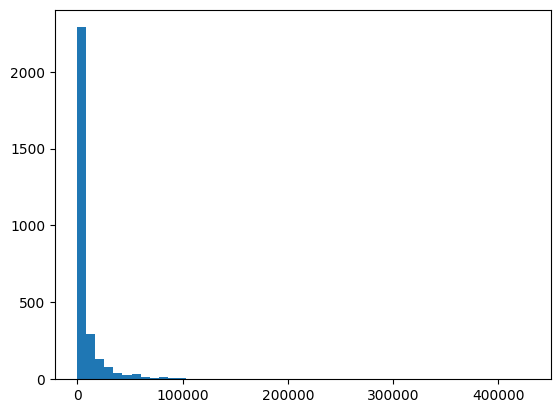

In [11]:
plt.hist(df_all['UltimateIncurredClaimCost'], bins=50, label='claim costs')
plt.show()

Besides our previous cleaning, we also transform the target variable with a log transformation, as the distribution is skewed.

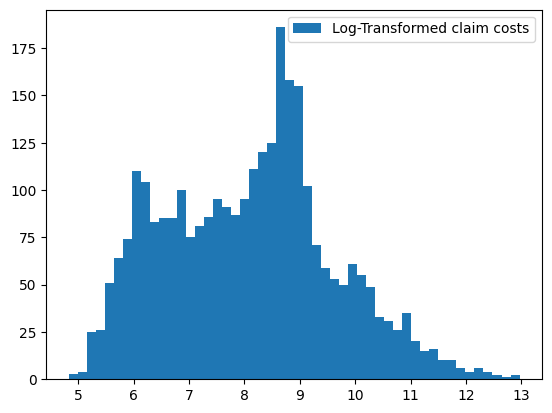

In [12]:
# Apply log transformation to the data
df_all['Log_UltimateIncurredClaimCost']= np.log(df_all['UltimateIncurredClaimCost'])

# Plot the original data and the log-transformed data
plt.hist(df_all['Log_UltimateIncurredClaimCost'], bins=50, label='Log-Transformed claim costs')
plt.legend()
plt.show()

### Preparing the features

To prepare features, we analyze and prepare features like date and categorical features such as gender and marital status. Specifically, we handle missing values, convert categorical variables into numerical format using one-hot encoding, and extract and engineer features from date columns.

In [13]:
# We first start with missing value imputation
df_all.isnull().sum()

ClaimNumber                      0
DateTimeOfAccident               0
DateReported                     0
Age                              0
Gender                           0
MaritalStatus                    2
DependentChildren                0
DependentsOther                  0
WeeklyWages                      0
PartTimeFullTime                 0
HoursWorkedPerWeek               0
DaysWorkedPerWeek                0
ClaimDescription                 0
InitialIncurredCalimsCost        0
UltimateIncurredClaimCost        0
number_of_body_parts_injured     0
main_body_part_injured           0
cause_of_injury                  0
Log_UltimateIncurredClaimCost    0
dtype: int64

In [14]:
df_all.groupby(df_all['MaritalStatus'])['UltimateIncurredClaimCost'].agg(['mean','median','count', 'std'])

,mean,median,count,std
MaritalStatus,,,,
M,12386.051069,4723.379658,1283,28899.614979
S,7625.593400,2436.555121,1417,19121.355793
U,17952.905272,5893.142513,298,36990.103642


In [15]:
df_all[df_all['MaritalStatus'].isnull()]['UltimateIncurredClaimCost'].agg(['mean','median','count', 'std'])

mean      3482.601382
median    3482.601382
count        2.000000
std       3290.078422
Name: UltimateIncurredClaimCost, dtype: float64

For missing values of marital status, we choose to impute these with S of Single, since the target variable distribution among Single individuals is most similar to the target variable distribution among cases with missing marital status.

In [16]:
#Replacing missing values with S of Single
df_all['MaritalStatus']=df_all['MaritalStatus'].fillna('S')

We adjust the categorical columns, creating one-hot encoded variables.

In [ ]:
df_all = df_all.join( pd.get_dummies(df_all[['MaritalStatus', 'Gender', 'PartTimeFullTime']], dtype=int))
df_all.drop(['Gender_F','MaritalStatus_U','PartTimeFullTime_P', 'Gender', 'MaritalStatus', 'PartTimeFullTime'],axis=1,inplace=True)

We also set columns containing date to the right format.

In [ ]:
df_all['DateTimeOfAccident']=pd.to_datetime(df_all['DateTimeOfAccident'])
df_all['DateReported']=pd.to_datetime(df_all['DateReported'])

df_all['Rep_Acc_Diff']=df_all['DateReported']-df_all['DateTimeOfAccident']
df_all['Rep_Acc_Diff']=df_all['Rep_Acc_Diff'].apply(lambda x:str(x)[:2])
df_all['Rep_Acc_Diff']=df_all['Rep_Acc_Diff'].astype('int')

df_all['Accident_Month']=df_all['DateTimeOfAccident'].dt.month
df_all['Accident_Year']=df_all['DateTimeOfAccident'].dt.year
df_all['Accident_Day']=df_all['DateTimeOfAccident'].dt.day
df_all['Accident_Hour']=df_all['DateTimeOfAccident'].dt.hour


df_all['Reported_Month']=df_all['DateReported'].dt.month
df_all['Reported_Year']=df_all['DateReported'].dt.year
df_all['Reported_Day']=df_all['DateReported'].dt.day

<h1 id="stage_3_categorizing" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">Stage 3: Categorizing LLM extracted content</h1>

In this section we categorize the extracted features from the LLM into predefined categories for both the cause of injury and the injured body part.
We define functions to map the extracted text to these categories using regular expressions. 
Finally, we apply these functions to the dataset to create new categorical columns `body_part_category` and `cause_of_injury_category`.
Note that one could also apply entity embedding to create relevant categorical columns.

In [19]:
df_all[['number_of_body_parts_injured', 'main_body_part_injured','cause_of_injury']].head()

,number_of_body_parts_injured,main_body_part_injured,cause_of_injury
0,1,LOWER BACK,strain
1,2,ELBOW,kneel
2,1,LEFT MIDDLE FINGER,caught
3,2,HAND,lacerate
4,1,RIGHT LOWER LEG,lacerate


In [20]:

def get_injury_cause_category(cause: str) -> str:
    """
    Returns the category for a given injury cause string.
    
    Args:
        cause: String describing the cause of injury
        
    Returns:
        String representing the injury cause category
    """
    if not cause or pd.isna(cause):
        return 'UNSPECIFIED'
    
    
    
    
    categories = {
    'LIFTING_CARRYING': r'(lift|lifting|carry|carrying|stack|stacking|hold|holding|unload|unloading|loading|transfer|move|moving|moved|push|pushing|pushed|pull|pulling|shovelling)',
    'IMPACT': r'(hit|struck|STRUCK|strike|thrown|flew|flying off|bang|collision|collide|collided|crash|knock|knocked over|bump|slam|slammed|puncture|burst|blew|blown|kick|kicked|kick back)',
    'FALL_SLIP_TRIP': r'(fall|fell|slip|slipped|trip|stumble|slide|sliding|drop|dropped|getting down|getting off|step out|stepping off|collapse|rolled|roll|gave way|landed)',
    'STRAIN_SPRAIN': r'(strain|strained|sprain|sprained|twist|twisted|twisting|bend|bend over|bending|overreach|overuse|overworking|repetitive strain|repetitive work|repetitive|stretch|wrench|kneel|kneeling)',
    'LACERATION': r'(cut|cutting|lacerate|lacerated|laceration|slice|slicing|grind|grinding|penetrate|penetrating|scrape|scratch|abrasion|shear|shearing|stab|pierced|punching)',
    'CHEMICAL_BURN': r'(burn|flash|splash|splashed|spill|spilled|spray|sprayed|welding|weld|boil|ignite|spark|rust|irritate|irritation)',
    'COMPRESSION': r'(caught|catching|jam|crush|crushed|pinched|pinned|squash|trap|lodged)',
    'CONTACT': r'(contact|shock|bite|bitten|sting|electrocute|attacked|assault|struck|stick|foreign body)',
    'ERGONOMIC': r'(use|using|deal|dealing|replace|operate|perform|typing|SEWING|work|assist|assisting|help|handling|packing|install|disconnect|cleaning|sweeping|sweep|drilling|drill|hammering|mop)',
    'WALKING': r'(walk|step|stepped|standing|stand|ran|run|run over|ran over|jump|climbing|climb|riding|wheeling|enter|entered|getting in|lean)',
    'DRIVING': r'(driving|drive|accident|collision)',
    'MEDICAL': r'(faint|injured|injury|fracture|fractured|torn|sustain|hurt|bruise|bruised|amputate)',
    'OTHER': r'(unspecified|failure|miss|misjudged|reaction|motion|movement|lose|close|flick|fly|grab|inhale|introduce|playing|restrain|shatter|snapped|trod|turn|turning)'
}

    
    # Check each category pattern
    for category, pattern in categories.items():
        if re.search(pattern, cause):
            return category
            
    return 'OTHER'

In [21]:

def get_body_part_category(body_part: str) -> str:
    """
    Returns the anatomical category for a given body part string.
    
    Args:
        body_part: String describing the body part
        
    Returns:
        String representing the anatomical category
    """
    if not body_part or pd.isna(body_part):
        return 'UNSPECIFIED'
    
    # Convert to uppercase for consistent processing
    part = str(body_part).upper()
    
    categories = {
        'HEAD_FACE': r'(HEAD|FACE|LIP|FOREHEAD|SCALP|JAW|MOUTH|CHIN|CHEEK|EAR|TEETH|TOOTH|SPECTACLES|GLASSES)',
        'EYES': r'(EYE|EYES|RIGHT EYE|LEFT EYE|RIGHT CORNEA|LEFT CORNEA|EYE CORNEA|EYELID)',
        'TORSO': r'(BACK|CHEST|RIBS|SIDE|INGUINAL REGION|UPPER BACK|MIDDLE BACK|LOWER BACK|LOW BACK|LOWER LEFT BACK|RIB CAGE|LEFT RIB CAGE|RIGHT RIBS|STOMACH|UPPER STOMACH|SOFT TISSUE|TAIL BONE|COCCYX|BACK BONE|THORACIC BACK|LUMBAR SPINE|LUMBAR|LUMBAR BACK|ABDOMEN|ABDOME|GROIN|LEFT GROIN|BUTTOCK|LEFT CHEST|LEFT CHEST WALL|INTERNAL|INGUINAL HERNIA|Lungs|LOWER MIDDLE BACK)',
        'UPPER_EXTREMITY': r'(ARM|ARMS|LEFT ARM|RIGHT ARM|UPPER ARM|UPPER RIGHT ARM|LEFT UPPER ARM|LOWER ARM|RIGHT LOWER ARM|SHOULDER|RIGHT SHOULDER|LEFT SHOULDER|RIGHT UPPER SHOULDER|ROTATOR CUFF|LEFT ROTATOR CUFF|ELBOW|LEFT ELBOW|RIGHT ELBOW|FOREARM|RIGHT FOREARM|LEFT FOREARM|LOWER FOREARM|RIGHT LOWER FOREARM|WRIST|WRISTS|LEFT WRIST|RIGHT WRIST)',
        'HAND_FINGERS': r'(HAND|HANDS|RIGHT HAND|LEFT HAND|LEFT HANDS|LEFT HAND, RIGHT HAND|PALM|LEFT PALM|FINGER|FINGERS|RIGHT FINGER|LEFT FINGER|LEFT FINGERS|INDEX FINGER|LEFT INDEX FINGER|RIGHT INDEX FINGER|LEFT HAND INDEX FINGER|MIDDLE FINGER|LEFT MIDDLE FINGER|RIGHT MIDDLE FINGER|MIDDLE LEFT FINGER|RING FINGER|RIGHT RING FINGER|LEFT RING FINGER|LEFT HAND RING FINGER|LITTLE FINGER|RIGHT LITTLE FINGER|LEFT LITTLE FINGER|THUMB|LEFT THUMB|RIGHT THUMB|LEFT THUMB FINGER|LEFT INDEX AND MIDDLE FINGER|RIGHT HAND FINGERS|LEFT HAND FINGERS|LEFT HAND MIDDLE FINGER|RIGHT HAND INDEX FINGER|LEFT HAND KNUCKLE|RIGHT BICEP)',
        'LOWER_EXTREMITY': r'(LEG|LEGS|LEFT LEG|RIGHT LOWER LEG|LOWER RIGHT LEG|LOWER LEFT LEG|LOWER LEG|LOWER LEFT LEG AND FOOT|KNEE|KNEES|RIGHT KNEE|LEFT KNEE|PATELLA|ANKLE|LEFT ANKLE|RIGHT ANKLE|FOOT|FEET|LEFT FOOT|RIGHT FOOT|TOE|TOES|LEFT TOE|RIGHT TOE|LEFT BIG TOE|BIG TOE|LEFT LITTLE TOE|RIGHT LITTLE TOE|THIGH|RIGHT THIGH|HIP|SHIN|RIGHT SHIN|CALF|LEFT CALF|HEEL)',
        'NECK': r'(NECK|LEFT NECK|CERVICAL SPINE|BACK and NECK)',
        'OTHER': r'(unspecified|BODY|WOUND|SKIN|MUSCLES|MUSCLE|TENDON|SCALE|FLASH|RIGHT|LEFT|INDEX)'
    }
    
    
    # Check each category pattern
    for category, pattern in categories.items():
        if re.search(pattern, part):
            return category
            
    return 'OTHER'



After mapping the existing classes to the right category, we apply the functions.

In [22]:
# Apply the categorization
df_all['body_part_category'] = df_all['main_body_part_injured'].apply(get_body_part_category)

df_all['cause_of_injury_category'] = df_all['cause_of_injury'].apply(get_injury_cause_category)

In [23]:
# Example print of results
df_all[['main_body_part_injured', 'body_part_category']].head()

,main_body_part_injured,body_part_category
0,LOWER BACK,TORSO
1,ELBOW,UPPER_EXTREMITY
2,LEFT MIDDLE FINGER,HAND_FINGERS
3,HAND,HAND_FINGERS
4,RIGHT LOWER LEG,LOWER_EXTREMITY


In [24]:
# Example print of results
df_all[['cause_of_injury', 'cause_of_injury_category']].head()

,cause_of_injury,cause_of_injury_category
0,strain,STRAIN_SPRAIN
1,kneel,STRAIN_SPRAIN
2,caught,COMPRESSION
3,lacerate,LACERATION
4,lacerate,LACERATION


<h1 id="stage_4_model" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">Stage 4: Model development & comparison</h1>

In this section, we compare the performance of the baseline model and the enhanced model that includes LLM-derived features. The comparison involves evaluating regression metrics such as RMSE, MAE, R2, and MAPE. Additionally, we analyze feature importance rankings for both models and perform a statistical significance test to determine if the improvements are significant.  This section provides insights into the added value of the LLM-derived features in predicting the target variable.

In [25]:
#Drop irrelevant columns
df_model = df_all.drop(columns=['InitialIncurredCalimsCost', 'ClaimDescription', 'ClaimNumber', 'DateTimeOfAccident',  'UltimateIncurredClaimCost', 'DateReported', 'cause_of_injury', 'main_body_part_injured'])


We then create two different data sets, one with the additional LLM features, the other one with only the base columns.

In [26]:
# Create df for enhanced model
df_encoded = pd.get_dummies(
    df_model,
    columns=['body_part_category', 'cause_of_injury_category'],
    prefix=['body', 'cause'],
    drop_first=True
)

In [27]:
# create df for baseline model
df_baseline = df_encoded.drop(columns=[col for col in df_encoded.columns if 'body' in col or 'cause' in col])

In [28]:
df_encoded.columns

Index(['Age', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'number_of_body_parts_injured', 'Log_UltimateIncurredClaimCost',
       'MaritalStatus_M', 'MaritalStatus_S', 'Gender_M', 'PartTimeFullTime_F',
       'Rep_Acc_Diff', 'Accident_Month', 'Accident_Year', 'Accident_Day',
       'Accident_Hour', 'Reported_Month', 'Reported_Year', 'Reported_Day',
       'body_HAND_FINGERS', 'body_HEAD_FACE', 'body_LOWER_EXTREMITY',
       'body_NECK', 'body_OTHER', 'body_TORSO', 'body_UPPER_EXTREMITY',
       'cause_COMPRESSION', 'cause_CONTACT', 'cause_DRIVING',
       'cause_ERGONOMIC', 'cause_FALL_SLIP_TRIP', 'cause_IMPACT',
       'cause_LACERATION', 'cause_LIFTING_CARRYING', 'cause_MEDICAL',
       'cause_OTHER', 'cause_STRAIN_SPRAIN', 'cause_WALKING'],
      dtype='object')

In [30]:
df_baseline.columns

Index(['Age', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'Log_UltimateIncurredClaimCost', 'MaritalStatus_M', 'MaritalStatus_S',
       'Gender_M', 'PartTimeFullTime_F', 'Rep_Acc_Diff', 'Accident_Month',
       'Accident_Year', 'Accident_Day', 'Accident_Hour', 'Reported_Month',
       'Reported_Year', 'Reported_Day'],
      dtype='object')

To fit our model, we create a pipeline that processes the data, trains the model and makes predictions and evaluations.

In [ ]:
# Pipeline to train the model
def create_xgboost_pipeline(
    data: pd.DataFrame,
    target_column: str,
    test_size: float = 0.2,
    random_state: int = 42
) -> tuple:
    """
    Creates and trains a sklearn Gradient Boosting regression pipeline with categorical handling.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing features and target
    target_column : str
        Name of the target column
    categorical_columns : list, optional
        List of categorical column names. If None, will try to automatically detect
    test_size : float, optional
        Proportion of dataset to include in the test split
    random_state : int, optional
        Random state for reproducibility
    
    Returns:
    --------
    tuple
        (trained_pipeline, X_train, X_test, y_train, y_test)
    """
    
    data_copy = data.copy()
    
    # Separate features and target
    X = data.drop(columns=[target_column])
    y = data_copy[target_column]
    

    # Create pipeline with sklearn's GradientBoostingRegressor
    pipeline = Pipeline([
        ('regressor', GradientBoostingRegressor(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=3,
            random_state=random_state
        ))
    ])
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    return pipeline, X_train, X_test, y_train, y_test

def predict_with_pipeline(pipeline, X: pd.DataFrame) -> np.ndarray:
    """
    Make predictions using the trained pipeline
    
    Parameters:
    -----------
    pipeline : sklearn.Pipeline
        Trained pipeline
    X : pandas.DataFrame
        Features to predict on
    
    Returns:
    --------
    numpy.ndarray
        Predictions
    """
    return pipeline.predict(X)

def evaluate_model(pipeline, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    """
    Evaluate the model performance
    
    Parameters:
    -----------
    pipeline : sklearn.Pipeline
        Trained pipeline
    X_test : pandas.DataFrame
        Test features
    y_test : pandas.Series
        Test target values
    
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    y_pred = pipeline.predict(X_test)
    
    return {
        'mse': mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }

Now we fit both the baseline model and the enhanced model.

In [36]:
# Create and train the pipeline
pipeline_bl, X_train, X_test, y_train, y_test = create_xgboost_pipeline(
    data=df_baseline,
    target_column= 'Log_UltimateIncurredClaimCost',
   
)

# Make predictions
predictions_bl = predict_with_pipeline(pipeline_bl, X_test)

# Evaluate the model
metrics_bl = evaluate_model(pipeline_bl,X_test, y_test)
print(metrics_bl)

{'mse': np.float64(1.8329756404558588), 'rmse': np.float64(1.3538743074805204), 'mae': np.float64(1.1114618555254265), 'r2': 0.2668698654631293}


In [37]:

# Create and train the pipeline
pipeline_eh, X_train_eh, X_test_eh, y_train_eh, y_test_eh = create_xgboost_pipeline(
    data=df_encoded,
    target_column= 'Log_UltimateIncurredClaimCost',
   
)

# Make predictions
predictions = predict_with_pipeline(pipeline_eh, X_test_eh)

# Evaluate the model
metrics = evaluate_model(pipeline_eh, X_test_eh, y_test_eh)
print(metrics)

{'mse': np.float64(1.2295973498980777), 'rmse': np.float64(1.108872107097152), 'mae': np.float64(0.8460417302740473), 'r2': 0.5082013908636742}


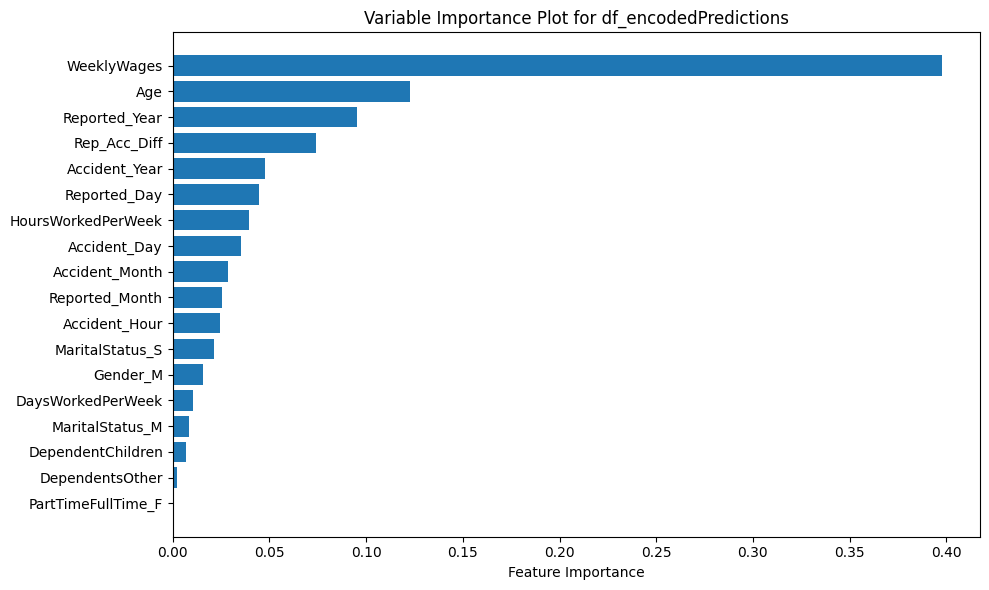

In [38]:
# Plot feature importance for df_baseline predictions
feature_importance = pipeline_bl.named_steps['regressor'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_baseline.drop(columns=['Log_UltimateIncurredClaimCost']).columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Variable Importance Plot for df_encodedPredictions')
plt.tight_layout()
plt.show()

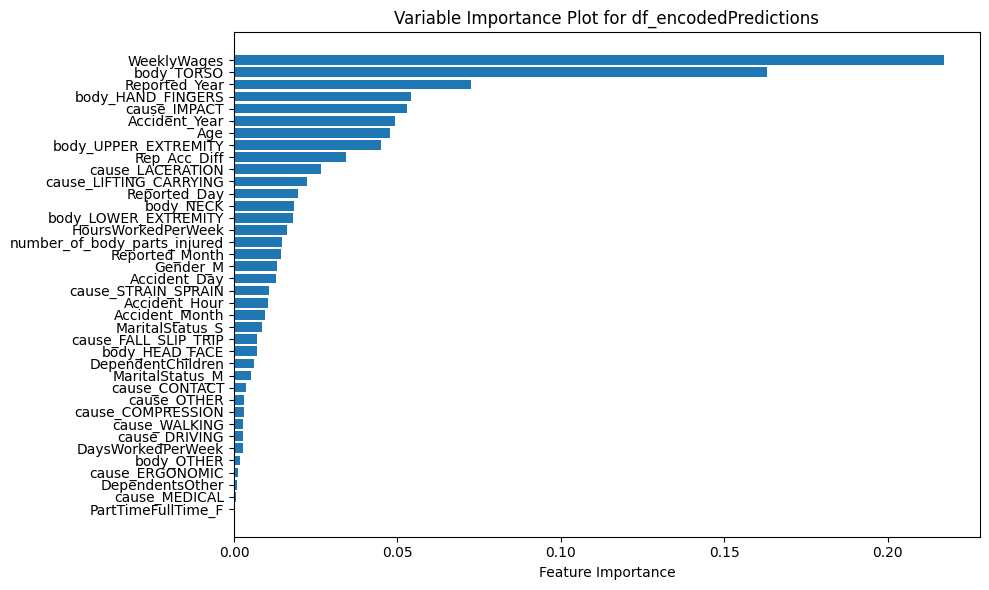

In [39]:
feature_importance = pipeline_eh.named_steps['regressor'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_encoded.drop(columns=['Log_UltimateIncurredClaimCost']).columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Variable Importance Plot for df_encodedPredictions')
plt.tight_layout()
plt.show()

In [40]:


def evaluate_model(y_true, y_pred):
    """Calculate various regression metrics."""
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    
    return pd.Series(metrics)

def compare_models(baseline_pipeline, enhanced_pipeline, 
                  X_baseline_test, X_enhanced_test, y_test, groups=None):
    """
    Compare two sklearn Pipeline models with GradientBoostingRegressor.
    
    Parameters:
    - baseline_pipeline: trained baseline Pipeline with GradientBoostingRegressor
    - enhanced_pipeline: trained enhanced Pipeline with GradientBoostingRegressor
    - X_baseline_test: test features for baseline model
    - X_enhanced_test: test features for enhanced model
    - y_test: true target values
    - groups: optional pandas Series for group-wise comparison
    """
    # Get predictions
    y_pred_baseline = baseline_pipeline.predict(X_baseline_test)
    y_pred_enhanced = enhanced_pipeline.predict(X_enhanced_test)
    
    # Overall performance comparison
    baseline_metrics = evaluate_model(y_test, y_pred_baseline)
    enhanced_metrics = evaluate_model(y_test, y_pred_enhanced)
    
    comparison_df = pd.DataFrame({
        'Baseline': baseline_metrics,
        'Enhanced': enhanced_metrics,
        'Improvement(%)': pd.Series({
        # For metrics where lower is better, use negative of the relative change
        'RMSE': -((enhanced_metrics['RMSE'] - baseline_metrics['RMSE']) / baseline_metrics['RMSE'] * 100),
        'MAE': -((enhanced_metrics['MAE'] - baseline_metrics['MAE']) / baseline_metrics['MAE'] * 100),
        'MAPE': -((enhanced_metrics['MAPE'] - baseline_metrics['MAPE']) / baseline_metrics['MAPE'] * 100),
        # For R2, higher is better, so keep the original calculation
        'R2': ((enhanced_metrics['R2'] - baseline_metrics['R2']) / baseline_metrics['R2'] * 100)
        })
    })
    # Feature importance comparison
    baseline_importance = pd.DataFrame({
        'feature': X_baseline_test.columns,
        'importance': baseline_pipeline.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    enhanced_importance = pd.DataFrame({
        'feature': X_enhanced_test.columns,
        'importance': enhanced_pipeline.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Residual analysis
    baseline_residuals = y_test - y_pred_baseline
    enhanced_residuals = y_test - y_pred_enhanced
    
    # Group-wise performance if groups are provided
    group_comparison = None
    if groups is not None:
        group_metrics = []
        for group_name in groups.unique():
            mask = groups == group_name
            group_metrics.append({
                'Group': group_name,
                'Baseline_RMSE': np.sqrt(mean_squared_error(y_test[mask], y_pred_baseline[mask])),
                'Enhanced_RMSE': np.sqrt(mean_squared_error(y_test[mask], y_pred_enhanced[mask])),
                'Baseline_R2': r2_score(y_test[mask], y_pred_baseline[mask]),
                'Enhanced_R2': r2_score(y_test[mask], y_pred_enhanced[mask])
            })
        group_comparison = pd.DataFrame(group_metrics)
    
    # Statistical significance test
    t_stat, p_value = stats.ttest_rel(
        np.abs(baseline_residuals),
        np.abs(enhanced_residuals)
    )
    
    
    return {
        'overall_metrics': comparison_df,
        'group_comparison': group_comparison,
        'feature_importance': {
            'baseline': baseline_importance,
            'enhanced': enhanced_importance
        },
        'statistical_test': {
            't_statistic': t_stat,
            'p_value': p_value
        },
        'residuals': {
            'baseline': baseline_residuals,
            'enhanced': enhanced_residuals
        }
    }

In [ ]:
# Compare the models
X_bl = df_baseline.drop(columns='Log_UltimateIncurredClaimCost')
X_eh = df_encoded.drop(columns='Log_UltimateIncurredClaimCost')

comparison_results = compare_models(
    pipeline_bl,
    pipeline_eh,
    X_test,
    X_test_eh,
    y_test,  # Assuming same test set target values
    groups=None  # Add groups if needed
)

# Print overall metrics
print("Overall Performance Comparison:")
print(comparison_results['overall_metrics'])

# Get feature importance rankings
print("\nTop 5 Important Features (Baseline):")
print(comparison_results['feature_importance']['baseline'].head())

print("\nTop 5 Important Features (Enhanced):")
print(comparison_results['feature_importance']['enhanced'].head())

# Check statistical significance
print("\nStatistical Test Results:")
print(f"t-statistic: {comparison_results['statistical_test']['t_statistic']}")
print(f"p-value: {comparison_results['statistical_test']['p_value']}")

Overall Performance Comparison:
       Baseline   Enhanced  Improvement(%)
MAE    1.111462   0.846042       23.880273
MAPE  14.519766  10.678322       26.456653
R2     0.266870   0.508201       90.430414
RMSE   1.353874   1.108872       18.096377

Top 5 Important Features (Baseline):
          feature  importance
3     WeeklyWages    0.397543
0             Age    0.122524
16  Reported_Year    0.095232
10   Rep_Acc_Diff    0.073981
12  Accident_Year    0.047769

Top 5 Important Features (Enhanced):
              feature  importance
3         WeeklyWages    0.217340
24         body_TORSO    0.163204
17      Reported_Year    0.072543
19  body_HAND_FINGERS    0.054193
31       cause_IMPACT    0.052903

Statistical Test Results:
t-statistic: 10.067203417734781
p-value: 3.9476304258128054e-22


# 
<h1 id="appendix_grid" style="font-size:22px; background-color: #E6E6E6; color: black; height: 50px; line-height: 50px;  padding-left: 14px;">Appendix: Hyperparameter optimization with grid search</h1>

The grid search in the provided code performs hyperparameter tuning for the `GradientBoostingRegressor` model. It systematically evaluates combinations of hyperparameters to find the best configuration that minimizes the error on the target variable.

##### Steps:
1. **Parameter Grid Definition**:
    - The grid search explores different values for `max_depth` (tree depth) and `n_estimators` (number of boosting stages).
    - Example values: `max_depth` = [3, 5, 7], `n_estimators` = [50, 100, 150, 200].

2. **Cross-Validation**:
    - A 5-fold cross-validation is used to split the data into training and validation sets.
    - This ensures the  performance is evaluated on multiple subsets of the data, reducing the risk of overfitting.

3. **Scoring Metric**:
    - The scoring metric used is negative mean squared error (`neg_mean_squared_error`), which is converted to RMSE for interpretability.

4. **Best Model Selection**:
    - The grid search identifies the combination of hyperparameters that results in the lowest RMSE.
    - The best model is then returned.

This process helps optimize the  performance by finding the most suitable hyperparameters for the given dataset.

In [51]:


def train_gbr_cv(data, target_column):
    """
    Performs 5-fold cross-validation with GradientBoostingRegressor
    
    Parameters:
    data: pandas DataFrame containing features and target
    target_column: string, name of the target column
    
    Returns:
    best_model: trained model with best parameters
    cv_results: dictionary containing cross-validation results
    """
    # Separate features and target
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    
    # Define parameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'n_estimators': [50, 100, 150, 200]
    }
    
    # Initialize model
    gbr = GradientBoostingRegressor(random_state=42)
    
    # Setup cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=gbr,
        param_grid=param_grid,
        cv=kf,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model
    grid_search.fit(X, y)
    
    # Get best model and results
    best_model = grid_search.best_estimator_
    cv_results = {
        'best_params': grid_search.best_params_,
        'best_score': np.sqrt(-grid_search.best_score_),  # Convert MSE to RMSE
        'cv_results': grid_search.cv_results_
    }
    
    # Print results
    print(f"Best parameters: {cv_results['best_params']}")
    print(f"Best RMSE: {cv_results['best_score']:.4f}")
    
    return best_model, cv_results

In [52]:
# Baseline model
best_model, cv_results = train_gbr_cv(df_baseline, 'Log_UltimateIncurredClaimCost')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': 3, 'n_estimators': 50}
Best RMSE: 1.3256


In [53]:
# Enhanced model
best_model, cv_results = train_gbr_cv(df_encoded, 'Log_UltimateIncurredClaimCost')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': 3, 'n_estimators': 200}
Best RMSE: 1.0960
